In [1]:
import os
import numpy as np 
np.random.seed(123)

import pandas as pd 
pd.set_option("display.max_rows", 1000)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest as ISOF
import umap
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, max_error
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity as kde

import keras as ks
import tensorflow as tf

from scipy import interpolate

import trimap
import pacmap

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

/Users/ozerozdal/anaconda3/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11103. The TBB threading layer is disabled.
  warnings.warn(problem)


# Red Wine Quality

In [18]:
Data = pd.read_csv("Data/winequality-red.csv")
Data.head(n=5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


To get a feeling for the data set, let's take a look at it first.

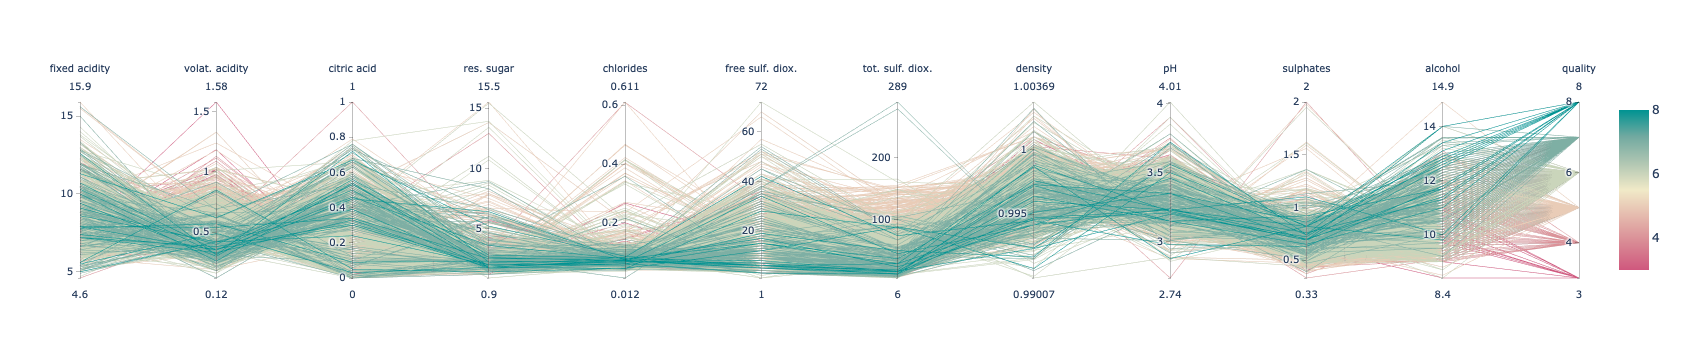

In [19]:
parCo = go.Figure(data=
    go.Parcoords(
        line = dict(color = Data['quality'],
                    colorscale = 'Tealrose',
                    showscale = True,
                    cmin = 3,
                    cmax = 8,
                    reversescale = True),
        dimensions = list([
            dict(label = "fixed acidity", 
                 values = Data['fixed acidity']),
            dict(label = 'volat. acidity', 
                 values = Data['volatile acidity']),
            dict(label = 'citric acid', 
                 values = Data['citric acid']),
            dict(label = 'res. sugar', 
                 values = Data['residual sugar']),
            dict(label = 'chlorides', 
                 values = Data['chlorides']),
            dict(label = 'free sulf. diox.', 
                 values = Data['free sulfur dioxide']),
            dict(label = 'tot. sulf. diox.', 
                 values = Data['total sulfur dioxide']),
            dict(label = 'density', 
                 values = Data['density']),
            dict(label = 'pH', 
                 values = Data['pH']),
            dict(label = 'sulphates', 
                 values = Data['sulphates']),
            dict(label = 'alcohol', 
                 values = Data['alcohol']),
            dict(label = 'quality', 
                 values = Data['quality']),
        ])
    )
)
parCo.show()

The better the wine the higher the alcohol percentage 🍷

The following methods are either based on the optimization of variances (PCA) or use distances (PCA, t-SNE, UMAP, TriMap, PaCMAP, DBSCAN) or they are neural networks that use weights. All of them have in common that the data should be normalized before. We will not go into the different methods of normalization for the time being. 

Why should distance-based methods be normalized? Well, suppose the scale of one variable (a) goes from 0 to 1 and that of another (b) goes from - 1000 to 1000. If we were to compute distance between the observations of a and b, this would of course be determined almost exclusively by b. The same applies to the calculation of variances.

Neural networks, on the other hand, simply have difficulties with backpropagation when the scales are very different. If the inputs are of different scales, the weights of some inputs will be updated much faster than other ones. 

In [20]:
def Normalization(DF, cols):
    DF=DF.copy()
    for c in cols:
        DF[f"{c}"] = ((DF["{}".format(c)]-DF["{0}".format(c)].mean()) / DF["{}".format(c)].std())
        
    return DF

In [21]:
Data = Normalization(DF=Data, cols=Data.drop(columns=["quality"]).columns)

In [22]:
Data.head(n=5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,5
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,5
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,5
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,6
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,5


<font size="+2" color="grey"><b>1.1 PCA (Principal Component Analysis) </b></font><br><a id="1.1"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

This method reframes the data into uncorrelated principal components. These components are linear representations of the original data. The total variance (What is equated here with information content) of all components is exactly equal to the total variance of the entire data set. The first component contains the most variance. With each component, the variance decreases, so that a large part of the total variance is in the first components. We will find this out later in this story.

In [23]:
Data.shape

(1599, 12)

In [24]:
Data.shape[1]

12

In [25]:
pca = PCA(n_components=Data.shape[1]-1, 
          random_state=1
          )

transformed = pca.fit_transform(Data.drop(columns=["quality"]))

In [26]:
Reduced = pd.DataFrame(transformed)

In [27]:
def scatterPlot(x,y,df,color,colorName="quality", a=0.65, main_title=""):
    df=df.copy()
    df[f"{colorName}"]=color
    #plt.figure(figsize=(12,9))

    s=sns.JointGrid(
        x=x, 
        y=y, 
        data=df, 
        hue=f"{colorName}",
        palette="viridis",
        height=10,
        ratio=5
        )
    s.plot_joint(sns.scatterplot, s=100, alpha=a)
    s.plot_marginals(sns.kdeplot, cut=0)
    s.fig.suptitle(main_title, fontsize=15)
    
    ax = plt.gca()
    #ax.set_title(main_title)

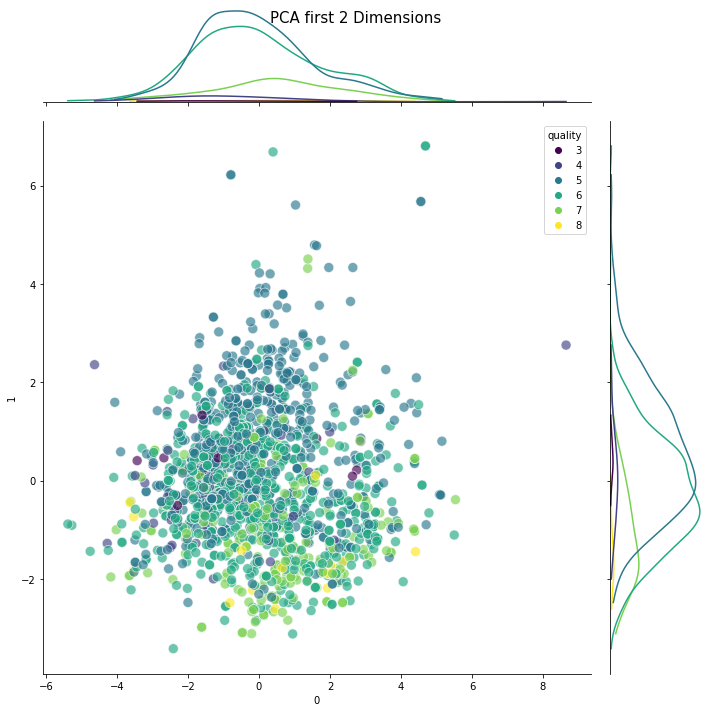

In [28]:
scatterPlot(x=0,y=1,df=Reduced,color=Data.quality, main_title="PCA first 2 Dimensions")

In [29]:
def barPlot(y, threshold):
    fig, axs = plt.subplots(1,2, figsize=(20,6))
    #plt.figure(figsize=(12,9))
    heights1=y
    heights2=y.cumsum()
    colors=heights2 >= threshold
    
    axs[0].bar(height=heights1, x=range(1,len(y)+1), width=0.8, color=["black" if x == True else "maroon" for x in colors])
    axs[0].set_xticks(ticks=range(1,len(y)+1))
    axs[0].set_yticks(ticks=np.array(list(range(0,11)))/10)
    
    axs[1].bar(height=heights2, x=range(1,len(y)+1), width=0.8, color=["black" if x == True else "maroon" for x in colors])
    axs[1].axhline(y=threshold, xmin=0, xmax=3, c="black")
    axs[1].set_xticks(ticks=range(1,len(y)+1))
    axs[1].set_yticks(ticks=np.array(list(range(0,11)))/10)
    axs[1].set_title("Cumul. Variance with " + str(sum(colors == False)+1) + " Components")
    plt.show()

Let's take a look at the variance of the components individually as well as cumulatively.

In [36]:
pca.explained_variance_ratio_

array([0.28173931, 0.1750827 , 0.1409585 , 0.11029387, 0.08720837,
       0.05996439, 0.05307193, 0.03845061, 0.0313311 , 0.01648483,
       0.00541439])

In [37]:
pca.explained_variance_ratio_.cumsum()

array([0.28173931, 0.45682201, 0.59778051, 0.70807438, 0.79528275,
       0.85524714, 0.90831906, 0.94676967, 0.97810077, 0.99458561,
       1.        ])

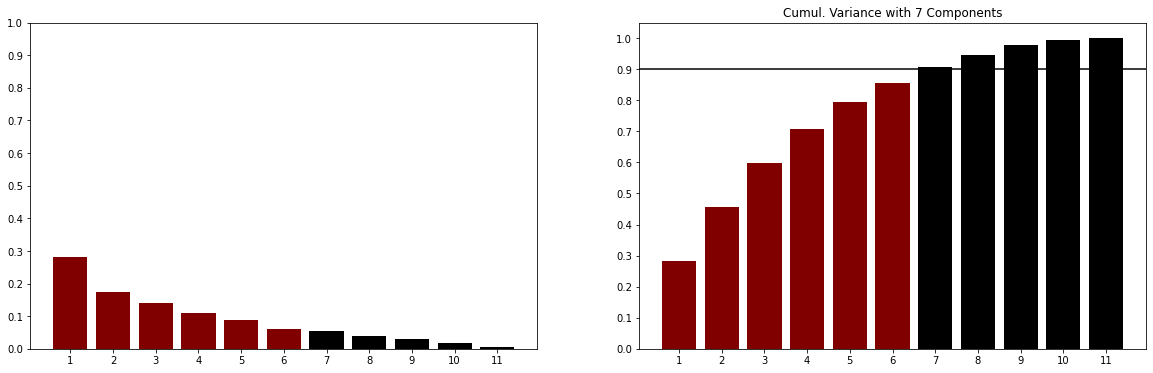

In [30]:
barPlot(y=pca.explained_variance_ratio_, threshold=0.9)

You can see that already with 7 components more than 90% of the variance is reached.

In [38]:
def total_variance(DF, subDF):
    variance, subVariance = 0, 0
    
    for c in DF.drop(columns=["quality"]).columns:
        variance = variance + np.var(DF["{0}".format(c)])
        
    for s in range(len(subDF.columns)):
        subVariance = subVariance + np.var(subDF.iloc[:,s])    
        
    result = "Variance left in reduced dimensions: " + str(round(subVariance / variance * 100, 1)) + " %"
    return result

In [43]:
total_variance(Data, Reduced.iloc[:,[0,1]])

'Variance left in reduced dimensions: 45.7 %'

An interesting question would be which method provides the most information in the two dimensions. One could take the two dimensions and try to explain the original data set, dimension by dimension, with them. The better this works, the more information should be contained. But be careful, the correlations between the reduced dimensions and the original data set are not necessarily linear. Thus we have to take a method that takes this non-linearity into account. Here I chose a Gradient Boosting Regressor with default parameters, because it adapts very well also non-linear correlations. To assess how good the explanatory power is, the R-square score, and the maximum error are used.

In [44]:
def Comparison(DF, subDF):
    """this function fits a svr with the reduced data as predictors to each original column iteratively with a loop. \n
 regression target = original column \n predictors = all columns for the reduced dataset"""
    
    DF=DF.copy()
    subDF=subDF.copy()
    subDF.columns=[str(i) for i in subDF.columns]
    
    r2=[]
    mae=[]
    maxErr=[]
    model = GBR()
    
    for i in range(DF.shape[1]):
        model.fit(X=subDF, y=DF.iloc[:,i])
        pred = model.predict(X=subDF)
        #r2.append(model.score(X=subDF, y=DF.iloc[:,i]))
        r2.append(r2_score(y_true=DF.iloc[:,i], y_pred=pred))
        mae.append(mean_absolute_error(y_true=DF.iloc[:,i], y_pred=pred))
        maxErr.append(max_error(y_true=DF.iloc[:,i], y_pred=pred))
        
        
    return r2, mae, maxErr

In [54]:
pcar2, pcamae, pcamaxerr=Comparison(Data, Reduced.iloc[:,[0,1]])
print(f" R2 score: ", pcar2)
print(f" Mean Absolute Error: ", pcamae)
print(f" Max Error: ", pcamaxerr)

 R2 score:  [0.8725240321729428, 0.541359145704262, 0.8170037133219433, 0.662668086738691, 0.7273418246810752, 0.6586269420980404, 0.8252359512671708, 0.770532720204401, 0.7090937591994035, 0.5234442852852121, 0.6335774349459155, 0.3836619438323595]
 Mean Absolute Error:  [0.272839116353603, 0.5218213088129101, 0.3340221572661885, 0.36569475578550603, 0.3043445152150579, 0.4496897056464427, 0.3149715511720885, 0.36909689985913796, 0.41570604811780104, 0.5181407508420183, 0.47530845880477546, 0.518295482613665]
 Max Error:  [1.7306105047807465, 2.8647516578078007, 2.439146842809118, 3.9750305434198503, 5.237071184411052, 2.615936835622337, 2.37321062345194, 2.393569030637168, 2.0388413066763813, 3.9763368481982964, 2.814225460125381, 2.40048446067067]
